# Brain2Img 

First attempt to decode the brain activation maps to the latent space

I will try with different approaches:

1) Linear mapping between fmri and latent space of VAE, VAEGAN and PGGAN
2) Convolutional network (optimizable) to map fmri to the latent spaces
3) Transformer approach to VQVAE

In [1]:
import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor
from torchsummary import summary 

import monai
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import glob

from classes.VAE import VAE, VAEGAN
from classes.VQVAE import VQVAE, VQVAE2


#from utils.utils import SeparableConv3D
from imutils import build_montages

from sklearn.preprocessing import MinMaxScaler
from torchvision.io import read_image

In [2]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


In [3]:
activation_path="/home/matteo/NeuroGEN/ds_proc/sub-01_activation"
activations=glob.glob(opj(activation_path,"*.nii.gz"))

idx=activations.index('/home/matteo/NeuroGEN/ds_proc/sub-01_activation/activation_constant.nii.gz')

print("removing ", idx)
del activations[idx]


removing  88


In [4]:
train_fraction=0.70
val_fraction=0.15
test_fraction=0.15

train_idx=int(len(activations)*train_fraction)
val_idx=int(train_idx+len(activations)*val_fraction)
test_idx=int(val_idx+len(activations)*test_fraction)

train_activations=activations[:train_idx]
val_activations=activations[train_idx:val_idx]
test_activations=activations[val_idx:]

print(f"Train: \t{len(train_activations)}\nVal: \t{len(val_activations)}\nTest: \t{len(test_activations)}")

Train: 	5921
Val: 	1268
Test: 	1270


In [5]:
vae_path="models/vae"
vaegan_path="/models/vaegan"
vqvae_path="/models/vqvae"

BS=64

## Dataloader

In [6]:

def get_img_path(name,basepath="/home/matteo/NeuroGEN/Dataset/Img/img_align_fmri_stimuli"):
    s=find_between(name,"activation_",".nii.gz")
    imagePath=opj(basepath,s)
    return imagePath

def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


class BrainDataset(Dataset):
    """Brain2img dataset."""

    def __init__(self, activations, nifti_transform=None,image_transform=None):

        self.activations = activations
        self.images=[get_img_path(i) for i in activations]
        
        self.nifti_transform = nifti_transform
        self.image_transform = image_transform
        
        self.niftireader=LoadImage(image_only=True)
        
        
    def __len__(self):
        return len(self.activations)

    def __getitem__(self, idx):
        
        
        
        act=self.niftireader(self.activations[idx])
        img=read_image(self.images[idx])
        
        if self.image_transform is not None:
            img = self.image_transform(img)/255.        
        if self.nifti_transform is not None:
            act = self.nifti_transform(act)
        

        act=torch.unsqueeze(act,0)
        return act,img

In [7]:
image_transforms=Compose([
 Resize((128,128)),
])
nifti_transforms=Compose([ToTensor()])



In [8]:
train_dataset = BrainDataset(train_activations,image_transform=image_transforms,nifti_transform=nifti_transforms)
val_dataset = BrainDataset(train_activations,image_transform=image_transforms,nifti_transform=nifti_transforms)
test_dataset = BrainDataset(train_activations,image_transform=image_transforms,nifti_transform=nifti_transforms)

train_dataloader=DataLoader(train_dataset,batch_size=BS,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=BS,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=BS,shuffle=True)


In [9]:
#check

a,i=next(iter(train_dataloader))

In [10]:
a.shape,i.shape

(torch.Size([64, 1, 41, 80, 80]), torch.Size([64, 3, 128, 128]))

# VAE Approach

3D convolutional

In [11]:
## VAE

encoder_architecture=[[1,512],[1,256],[1,128],[1,64],[1,32]]
decoder_architecture=[[3,64],[2,128],[1,256],[0,384],[0,512]]

latent_dim=1024
input_dim=(3,128,128)

vae=VAE(input_dim=input_dim,latent_dim=latent_dim,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture)

vae.to(device)
vae.load_state_dict(torch.load(r"models/vae/model.ckp"))


/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [12]:
class convBrain(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Conv3d(in_channels=1,out_channels=32,kernel_size=4,padding=1,stride=2),
            nn.Tanh(),
            nn.Conv3d(in_channels=32,out_channels=64,kernel_size=4,padding=1,stride=2),
            nn.Tanh(),
            nn.Conv3d(in_channels=64,out_channels=128,kernel_size=4,padding=1,stride=2),
            nn.Tanh(),
            nn.Conv3d(in_channels=128,out_channels=2,kernel_size=5,padding="same"),
            nn.Flatten(),
            nn.LazyLinear(1024),
        )
        
    def forward(self,x):
        return self.model(x)

In [13]:
convbrain=convBrain()

In [14]:
summary(convbrain,(1,41,80,80),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 20, 40, 40]           2,080
              Tanh-2       [-1, 32, 20, 40, 40]               0
            Conv3d-3       [-1, 64, 10, 20, 20]         131,136
              Tanh-4       [-1, 64, 10, 20, 20]               0
            Conv3d-5       [-1, 128, 5, 10, 10]         524,416
              Tanh-6       [-1, 128, 5, 10, 10]               0
            Conv3d-7         [-1, 2, 5, 10, 10]          32,002
           Flatten-8                 [-1, 1000]               0
            Linear-9                 [-1, 1024]       1,025,024
Total params: 1,714,658
Trainable params: 1,714,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.00
Forward/backward pass size (MB): 20.53
Params size (MB): 6.54
Estimated Total Size (MB): 28.07
-------------------------------------

## End-to-end model

With pretrained VAE's decoder

In [15]:
class brain2vae(nn.Module):
    def __init__(self,brain_model,decoder_model):
        super().__init__()
        self.brain_model=brain_model
        self.decoder_model=decoder_model
        
    def forward(self,x):
        z=self.brain_model(x)
        x=self.decoder_model(z)
        return x
    
        

In [16]:
## check ricostruzioni
with torch.no_grad():
    ir=vae(i.to(device))

In [ ]:
## check output modello

torch.cuda.empty_cache()
model=brain2vae(convbrain,vae.decoder).to(device)


out=model(a.to(device))

### Reconstruction check

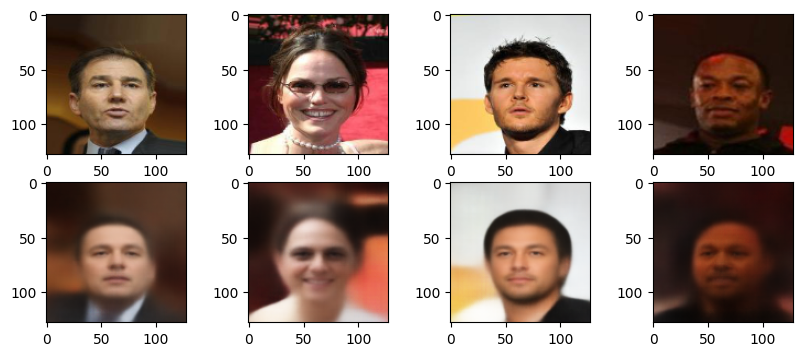

In [29]:
fig,axs=plt.subplots(2,4,figsize=(10,4))

for idx in range(4):
    axs[0,idx].imshow(i[idx].detach().cpu().permute(1,2,0))
    axs[1,idx].imshow(ir[idx].detach().cpu().permute(1,2,0))
    
plt.show()

### Random reconstruction with model initiliazed

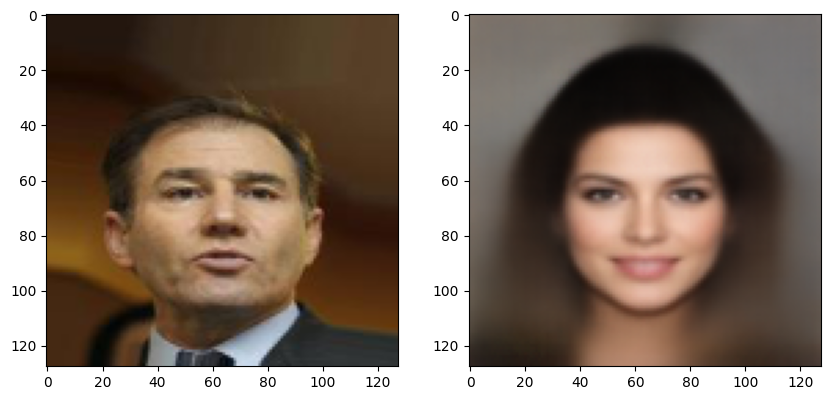

In [27]:
fig,axs=plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(i[0].permute(1,2,0).detach().cpu())
axs[1].imshow(out[0].permute(1,2,0).detach().cpu())
plt.show()

## Training loop 

In [ ]:
optimizer=torch.optim.Adam(convbrain.parameters(),lr=1e-4)
criterion=nn.BCELoss()

In [ ]:
def train(train_dataloader,epochs=10,optimizer=optimizer,val_dataloader=None):
    